In [1]:
%matplotlib inline


In [12]:
import glob
from skimage import io
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import Markdown, display

import torch
import torch.utils.data
from torch.autograd import Variable
import torch.nn as nn
from torchsummary import summary

import pandas as pd
import sys
sys.path.append("../")

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

In [13]:
np.random.seed(99)
torch.manual_seed(99)

In [14]:

races_to_consider = [0,4]
unprivileged_groups = [{'race': 4.0}]
privileged_groups = [{'race': 0.0}]
favorable_label = 0.0 
unfavorable_label = 1.0

In [15]:

image_dir = '/Users/shilpibhattacharyya/Downloads/UTKFace/'
img_size = 64

In [16]:
protected_race = []
outcome_gender = []
feature_image = []
feature_age = []

for i, image_path in enumerate(glob.glob(image_dir + "*.jpg")):
    try:
        age, gender, race = image_path.split('/')[-1].split("_")[:3]
        age = int(age)
        gender = int(gender)
        race = int(race)
        
        if race in races_to_consider:
            protected_race.append(race)
            outcome_gender.append(gender)
            feature_image.append(resize(io.imread(image_path), (img_size, img_size)))
            feature_age.append(age)
    except:
        print("Missing: " + image_path)

feature_image_mat = np.array(feature_image)
outcome_gender_mat =  np.array(outcome_gender)
protected_race_mat =  np.array(protected_race)
age_mat = np.array(feature_age)


/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Missing: /Users/shilpibhattacharyya/Downloads/UTKFace/39_1_20170116174525125.jpg.chip.jpg
Missing: /Users/shilpibhattacharyya/Downloads/UTKFace/61_1_20170109150557335.jpg.chip.jpg
Missing: /Users/shilpibhattacharyya/Downloads/UTKFace/61_1_20170109142408075.jpg.chip.jpg


In [17]:
class ThreeLayerCNN(torch.nn.Module):
    """
    Input: 128x128 face image (eye aligned).
    Output: 1-D tensor with 2 elements. Used for binary classification.
    Parameters:
        Number of conv layers: 3
        Number of fully connected layers: 2       
    """
    def __init__(self):
        super(ThreeLayerCNN,self).__init__()
        self.conv1 = torch.nn.Conv2d(3,6,5)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv2 = torch.nn.Conv2d(6,16,5)
        self.conv3 = torch.nn.Conv2d(16,16,6)
        self.fc1 = torch.nn.Linear(16*4*4,120)
        self.fc2 = torch.nn.Linear(120,2)


    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = x.view(-1,16*4*4)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
feature_image_mat_normed = 2.0 *feature_image_mat.astype('float32') - 1.0

N = len(feature_image_mat_normed)
ids = np.random.permutation(N)
train_size=int(0.7 * N)
X_train = feature_image_mat_normed[ids[0:train_size]]
y_train = outcome_gender_mat[ids[0:train_size]]
X_test = feature_image_mat_normed[ids[train_size:]]
y_test = outcome_gender_mat[ids[train_size:]]

p_train = protected_race_mat[ids[0:train_size]]
p_test = protected_race_mat[ids[train_size:]]

age_train = age_mat[ids[0:train_size]]
age_test = age_mat[ids[train_size:]]

In [19]:
batch_size = 64

X_train = X_train.transpose(0,3,1,2)
X_test = X_test.transpose(0,3,1,2)

train = torch.utils.data.TensorDataset(Variable(torch.FloatTensor(X_train.astype('float32'))), Variable(torch.LongTensor(y_train.astype('float32'))))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test = torch.utils.data.TensorDataset(Variable(torch.FloatTensor(X_test.astype('float32'))), Variable(torch.LongTensor(y_test.astype('float32'))))
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ThreeLayerCNN().to(device)
summary(model, (3,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 60, 60]             456
         MaxPool2d-2            [-1, 6, 30, 30]               0
            Conv2d-3           [-1, 16, 26, 26]           2,416
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5             [-1, 16, 8, 8]           9,232
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                  [-1, 120]          30,840
            Linear-8                    [-1, 2]             242
Total params: 43,186
Trainable params: 43,186
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.32
Params size (MB): 0.16
Estimated Total Size (MB): 0.53
----------------------------------------------------------------


In [21]:
num_epochs = 5
learning_rate = 0.001
print_freq = 100

# Specify the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training the model
num_batches = len(train_loader)
for epoch in range(num_epochs):
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (idx+1) % print_freq == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, idx+1, num_batches, loss.item()))

Epoch [1/5], Step [100/129], Loss: 0.4559
Epoch [2/5], Step [100/129], Loss: 0.4887
Epoch [3/5], Step [100/129], Loss: 0.2706
Epoch [4/5], Step [100/129], Loss: 0.2723
Epoch [5/5], Step [100/129], Loss: 0.2519


In [25]:
# Run model on test set in eval mode.
model.eval()
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted.tolist()
y_pred = np.array(y_pred)

In [27]:

def dataset_wrapper(outcome, protected, unprivileged_groups, privileged_groups,
                          favorable_label, unfavorable_label):
    """ A wraper function to create aif360 dataset from outcome and protected in numpy array format.
    """
    df = pd.DataFrame(data=outcome,
                      columns=['outcome'])
    df['race'] = protected
    
    dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                       unfavorable_label=unfavorable_label,
                                       df=df,
                                       label_names=['outcome'],
                                       protected_attribute_names=['race'],
                                       unprivileged_protected_attributes=unprivileged_groups)
    return dataset



In [29]:
original_traning_dataset = dataset_wrapper(outcome=y_train, protected=p_train, 
                                                 unprivileged_groups=unprivileged_groups, 
                                                 privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)
original_test_dataset = dataset_wrapper(outcome=y_test, protected=p_test, 
                                              unprivileged_groups=unprivileged_groups, 
                                              privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)
plain_predictions_test_dataset = dataset_wrapper(outcome=y_pred, protected=p_test, 
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)

In [30]:
classified_metric_nodebiasing_test = ClassificationMetric(original_test_dataset, 
                                                 plain_predictions_test_dataset,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)

In [31]:
display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Statistical parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil index = %f" % classified_metric_nodebiasing_test.theil_index())
print("Test set: False negative rate difference = %f" % classified_metric_nodebiasing_test.false_negative_rate_difference())

#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.866610
Test set: Balanced classification accuracy = 0.864336
Test set: Statistical parity difference = -0.101543
Test set: Disparate impact = 0.822329
Test set: Equal opportunity difference = -0.083823
Test set: Average odds difference = -0.039768
Test set: Theil index = 0.085988
Test set: False negative rate difference = 0.083823


In [32]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(original_traning_dataset)
transf_traning_dataset = RW.transform(original_traning_dataset)

In [33]:
metric_orig_train = BinaryLabelDatasetMetric(original_traning_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
metric_tranf_train = BinaryLabelDatasetMetric(transf_traning_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

In [34]:
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_train.mean_difference())
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_tranf_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between privileged and unprivileged groups = -0.096604


#### Transformed training dataset

Difference in mean outcomes between privileged and unprivileged groups = 0.000000


In [35]:
metric_orig_test = BinaryLabelDatasetMetric(original_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
transf_test_dataset = RW.transform(original_test_dataset)
metric_transf_test = BinaryLabelDatasetMetric(transf_test_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original testing dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_orig_test.mean_difference())
display(Markdown("#### Transformed testing dataset"))
print("Difference in mean outcomes between privileged and unprivileged groups = %f" % metric_transf_test.mean_difference())

#### Original testing dataset

Difference in mean outcomes between privileged and unprivileged groups = -0.087639


#### Transformed testing dataset

Difference in mean outcomes between privileged and unprivileged groups = 0.008971


In [36]:
tranf_train = torch.utils.data.TensorDataset(Variable(torch.FloatTensor(X_train.astype('float32'))),
                                             Variable(torch.LongTensor(transf_traning_dataset.labels.astype('float32'))),
                                            Variable(torch.FloatTensor(transf_traning_dataset.instance_weights.astype('float32'))),)
tranf_train_loader = torch.utils.data.DataLoader(tranf_train, batch_size=64, shuffle=True)

In [37]:
class InstanceWeighetedCrossEntropyLoss(nn.Module):
    """Cross entropy loss with instance weights."""
    def __init__(self):
        super(InstanceWeighetedCrossEntropyLoss, self).__init__()

    def forward(self, logits, target, weights):
        loss = log_sum_exp(logits) - select_target_class(logits, target.squeeze(1))
        loss = loss * weights
        return loss.mean()

#Helper functions
def select_target_class(logits, target):
    batch_size, num_classes = logits.size()
    mask = torch.autograd.Variable(torch.arange(0, num_classes)
                                               .long()
                                               .repeat(batch_size, 1)
                                               .to(device)
                                               .eq(target.data.repeat(num_classes, 1).t()))
    return logits.masked_select(mask)

def log_sum_exp(x):
    c, _ = torch.max(x, 1)
    y = c + torch.log(torch.exp(x - c.unsqueeze(dim=1).expand_as(x)).sum(1))
    return y

In [38]:
tranf_model = ThreeLayerCNN().to(device)


In [39]:
num_epochs = 5
learning_rate = 0.001
print_freq = 100

# Specify the loss and the optimizer
criterion = InstanceWeighetedCrossEntropyLoss()
optimizer = torch.optim.Adam(tranf_model.parameters(), lr=learning_rate)

# Start training the new model
num_batches = len(tranf_train_loader)
for epoch in range(num_epochs):
    for idx, (images, labels, weights) in enumerate(tranf_train_loader):

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = tranf_model(images)
        loss = criterion(outputs, labels, weights)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (idx+1) % print_freq == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, idx+1, num_batches, loss.item()))

Epoch [1/5], Step [100/129], Loss: 0.5977
Epoch [2/5], Step [100/129], Loss: 0.4117
Epoch [3/5], Step [100/129], Loss: 0.3861
Epoch [4/5], Step [100/129], Loss: 0.3440
Epoch [5/5], Step [100/129], Loss: 0.2706


In [40]:
# Test the model
tranf_model.eval()
y_pred_transf = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = tranf_model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred_transf += predicted.tolist()
y_pred_transf = np.array(y_pred_transf)

In [41]:
transf_predictions_test_dataset = dataset_wrapper(outcome=y_pred_transf, protected=p_test, 
                                                  unprivileged_groups=unprivileged_groups,
                                                  privileged_groups=privileged_groups,
                                                 favorable_label=favorable_label,
                                                  unfavorable_label=unfavorable_label
                                                 )

In [42]:
classified_metric_debiasing_test = ClassificationMetric(original_test_dataset, 
                                                 transf_predictions_test_dataset,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)

In [43]:
display(Markdown("#### Plain model - without debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Statistical parity difference = %f" % classified_metric_nodebiasing_test.statistical_parity_difference())
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())
print("Test set: False negative rate difference = %f" % classified_metric_nodebiasing_test.false_negative_rate_difference())

display(Markdown("#### Model - with debiasing - classification metrics"))
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Statistical parity difference = %f" % classified_metric_debiasing_test.statistical_parity_difference())
print("Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_debiasing_test.theil_index())
print("Test set: False negative rate difference = %f" % classified_metric_debiasing_test.false_negative_rate_difference())

#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.866610
Test set: Balanced classification accuracy = 0.864336
Test set: Statistical parity difference = -0.101543
Test set: Disparate impact = 0.822329
Test set: Equal opportunity difference = -0.083823
Test set: Average odds difference = -0.039768
Test set: Theil_index = 0.085988
Test set: False negative rate difference = 0.083823


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.848768
Test set: Balanced classification accuracy = 0.855244
Test set: Statistical parity difference = -0.115225
Test set: Disparate impact = 0.753367
Test set: Equal opportunity difference = -0.095048
Test set: Average odds difference = -0.054926
Test set: Theil_index = 0.140974
Test set: False negative rate difference = 0.095048


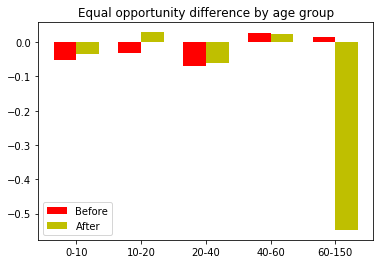

In [44]:
# Metrics sliced by age
age_range_intervals = [0, 10, 20, 40, 60, 150]
nodebiasing_perf = []
debiasing_perf = []

for idx in range(len(age_range_intervals)-1):
    start = age_range_intervals[idx]
    end = age_range_intervals[idx+1]
    ids = np.where((age_test>start) & (age_test<end))
    true_dataset = dataset_wrapper(outcome=y_test[ids], protected=p_test[ids],
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups,
                                   favorable_label=favorable_label,
                                unfavorable_label=unfavorable_label)
    transf_pred_dataset = dataset_wrapper(outcome=y_pred_transf[ids], protected=p_test[ids],
                                          unprivileged_groups=unprivileged_groups,
                                          privileged_groups=privileged_groups,
                                          favorable_label=favorable_label,
                                          unfavorable_label=unfavorable_label)
    pred_dataset = dataset_wrapper(outcome=y_pred[ids], protected=p_test[ids],
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups,
                                   favorable_label=favorable_label,
                                   unfavorable_label=unfavorable_label)
 
    classified_metric_nodebiasing_test = ClassificationMetric(true_dataset, 
                                                 pred_dataset,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    classified_metric_debiasing_test = ClassificationMetric(true_dataset, 
                                                 transf_pred_dataset,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    nodebiasing_perf.append(classified_metric_nodebiasing_test.equal_opportunity_difference())
    debiasing_perf.append(classified_metric_debiasing_test.equal_opportunity_difference())

N = len(age_range_intervals)-1
fig, ax = plt.subplots()
ind = np.arange(N)
width = 0.35
p1 = ax.bar(ind, nodebiasing_perf, width, color='r')
p2 = ax.bar(ind + width, debiasing_perf, width,
            color='y')
ax.set_title('Equal opportunity difference by age group')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels([str(age_range_intervals[idx])+'-'+str(age_range_intervals[idx+1]) for idx in range(N)])

ax.legend((p1[0], p2[0]), ('Before', 'After'))
ax.autoscale_view()

plt.show()